In [1]:
import sys
import re
from collections import defaultdict
from pprint import pprint
from joblib import Parallel, delayed
import time

WAV_FILE_PATH = 'data/input/waveforms_new.root'
DATASET_PATH = 'data/dataset/dataset.pkl'

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD

# Load file

In [2]:
N_JOBS = 8

In [3]:
SECTOR = 'sector 56'
STATION = 'station 220cyl'
RP = 'cyl_hr'

data_dir = f'wav/CTPPS/TimingDiamond/{SECTOR}/{STATION}/{RP}'

In [4]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw[data_dir].keys(recursive=False))

103674

In [5]:
sorted_events = sorted(file_raw[data_dir].keys(recursive=False), key=lambda x: int(x[6:-2]))
sorted_events[:20]

['event 3375;1',
 'event 6341;1',
 'event 7535;1',
 'event 8570;1',
 'event 9831;1',
 'event 9900;1',
 'event 10650;1',
 'event 11542;1',
 'event 13050;1',
 'event 14400;1',
 'event 15834;1',
 'event 15880;1',
 'event 17250;1',
 'event 17550;1',
 'event 18291;1',
 'event 19792;1',
 'event 20290;1',
 'event 22036;1',
 'event 23032;1',
 'event 24253;1']

# Produce the dataset

In [6]:
class WaveformData:
    def __init__(self, series, fpga_timestamp, timestampA, timestampB, cell_info, t0):
        self.series = series
        self.fpga_timestamp = fpga_timestamp
        self.timestampA = timestampA
        self.timestampB = timestampB
        self.cell_info = cell_info
        self.t0 = t0
        self.t_cfd = None
        
    @classmethod
    def from_channel_data(cls, channel_data):
        series = np.array(channel_data['wavCal'].values())
        fpga_timestamp = channel_data['fpgaTimestamp'].members['fVal']
        timestampA = channel_data['timestampA'].members['fVal']
        timestampB = channel_data['timestampB'].members['fVal']
        cell_info = channel_data['cellInfo'].members['fVal']
        t0 = channel_data['t0'].members['fVal']
        return cls(series, fpga_timestamp, timestampA, timestampB, cell_info, t0)
    
    def get_metadata_str(self):
        return {
            't0': self.t0,
            'fpga_timestamp': self.fpga_timestamp,
            'timestampA': self.timestampA,
            'timestampB': self.timestampB,
            'cell_info': self.cell_info,
            't0': self.t0,
            't_cfd': self.t_cfd
        }.__str__()
    
class EventData:
    def __init__(self, planes):
        self.planes = planes
        self.t_cfd_average = None
        
    @classmethod
    def from_event_data(cls, event_data):
        planes = {}
        for plane_key, plane_data in event_data.items(recursive=False):
            plane_name = int(plane_key[6:-2])
            planes[plane_name] = {}
            for channel_key, channel_data in plane_data.items(recursive=False):
                channel_name = int(channel_key[8:-2])
                planes[plane_name][channel_name] = WaveformData.from_channel_data(channel_data)
        return cls(planes)
    
    def __str__(self):
        return {f'plane {plane_name}': {f'channel {channel_name}': f't0: {wav_data.t0}' for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}.__str__()
    
    def get_metadata_dict(self):
        return {f'plane {plane_name}': {f'channel {channel_name}': wav_data.get_metadata_str() for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}
    
    def get_plane_count(self):
        return len(self.planes)
    
    def get_hit_count(self):
        return sum(len(channels) for channels in self.planes.values())
    
    def get_all_waveforms(self):
        wavs = []
        for plane, channels in self.planes.items():
            for channel, wav_data in channels.items():
                wavs.append((plane, channel, wav_data))
                
        return wavs

In [7]:
# def find_slices(length, n):
#     interval = length // n
#     slices = [i * interval for i in range(n)] + [length]
#     return slices

# def transform_event_collection(file_raw, data_dir, events):
#     dataset = []
#     for event in events:
#         event_int = int(event[6:-2])
#         event_data = file_raw[data_dir][event]
#         dataset.append((event_int, EventData.from_event_data(event_data)))
#     return dataset

# start = time.time()
# slices = find_slices(len(sorted_events), N_JOBS)
# dataset = Parallel(n_jobs=N_JOBS)(delayed(transform_event_collection)(file_raw, data_dir, sorted_events[slices[i]:slices[i+1]]) for i in range(len(slices) - 1))
# dataset = dict(sum(dataset, []))
# end = time.time()
# print(f'Elapsed time: {end - start:0.2f} s')

# # store the dataset
# with open(DATASET_PATH, 'wb') as file:
#     pickle.dump(dataset, file)
    
# load the dataset
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

In [8]:
print(dataset[3375])

{'plane 1': {'channel 11': 't0: -8.286604881286621'}, 'plane 2': {'channel 11': 't0: 0.12372398376464844'}, 'plane 3': {'channel 11': 't0: -5.702384948730469'}}


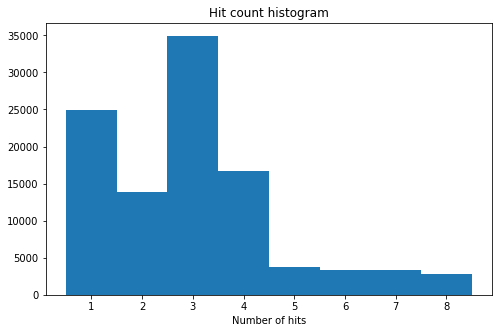

In [9]:
def plot_hit_count_histogram(dataset):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.figure(figsize=(8, 5))
    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title('Hit count histogram')
    plt.xlabel('Number of hits')
    plt.show()
    
plot_hit_count_histogram(dataset)

In [10]:
file_raw.close()

# t0 histograms

In [11]:
t0_dict = defaultdict(list)
for event_data in dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

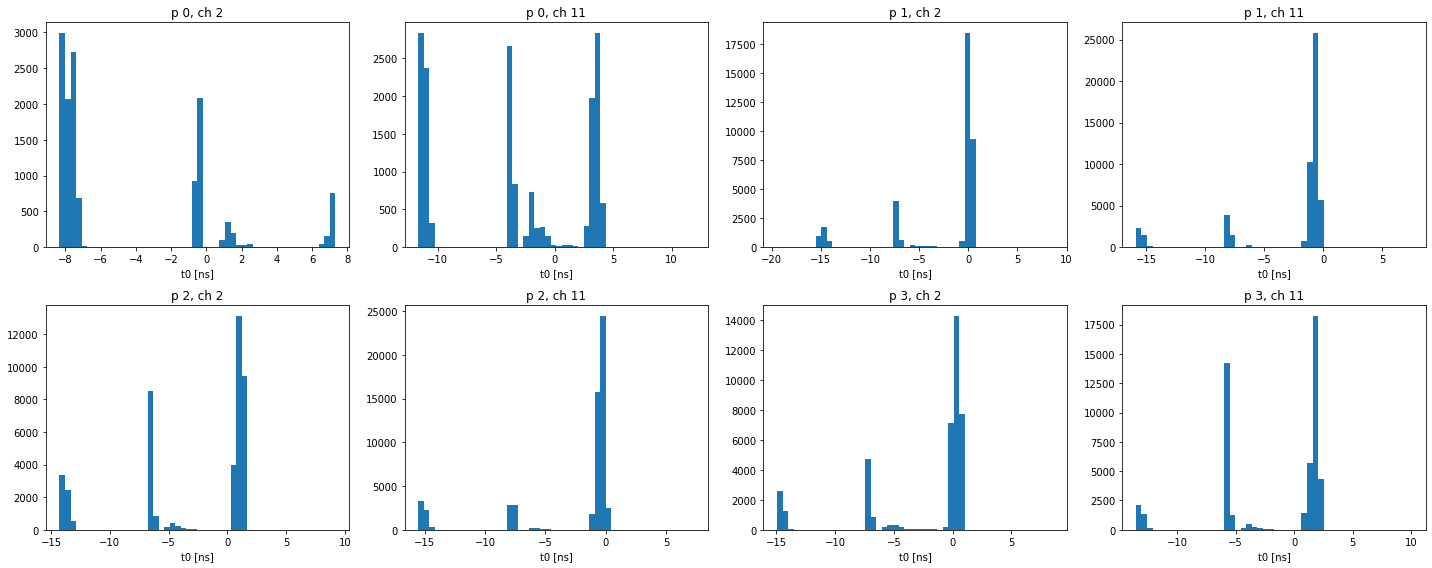

In [12]:
plt.figure(figsize=(20, 8))

for i, (plane, channel) in enumerate(sorted(t0_dict.keys())):
    t0_arr = t0_dict[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(t0_arr, bins=50)
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('t0 [ns]')
    
plt.tight_layout()
plt.show()

# Calculate CFD timestamps

In [13]:
cfd = CFD(n_baseline=6)
for event, event_data in dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            wav_data.t_cfd = cfd.predict(wav_data.series[0], wav_data.series[1])

# Examples

In [14]:
events_to_view = []
for event, event_data in dataset.items():
    if event_data.get_plane_count() == 4 and event_data.get_hit_count() == 4:
        events_to_view.append(event)
    if len(events_to_view) == 8:
        break
        
events_to_view

[19792, 24253, 28186, 29933, 54450, 57600, 64950, 107178]

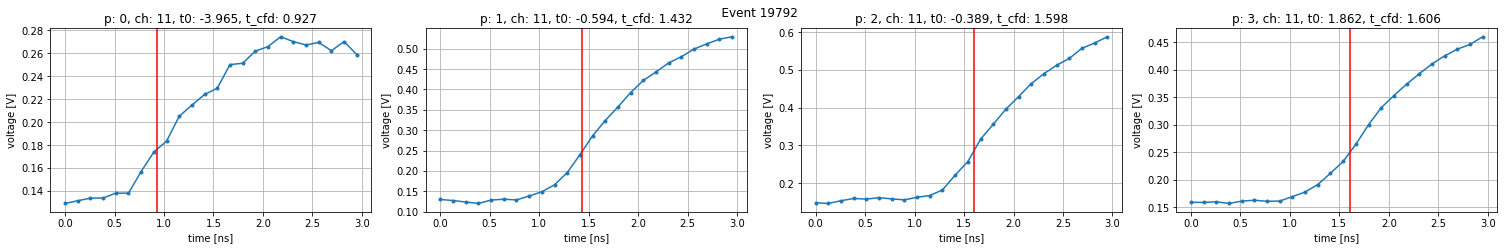

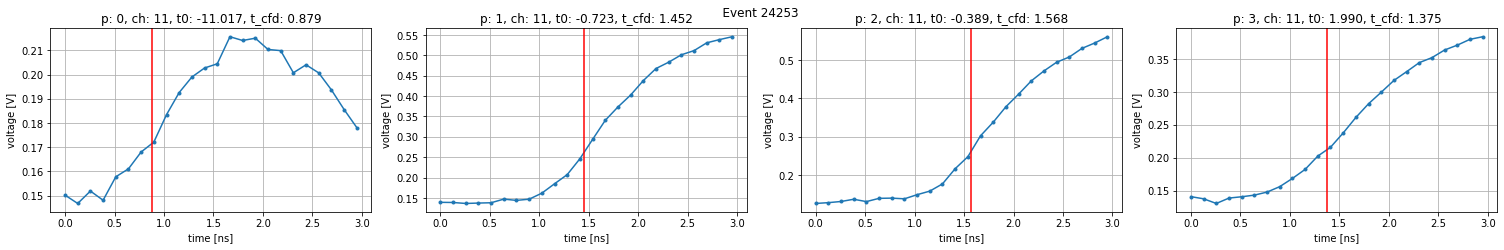

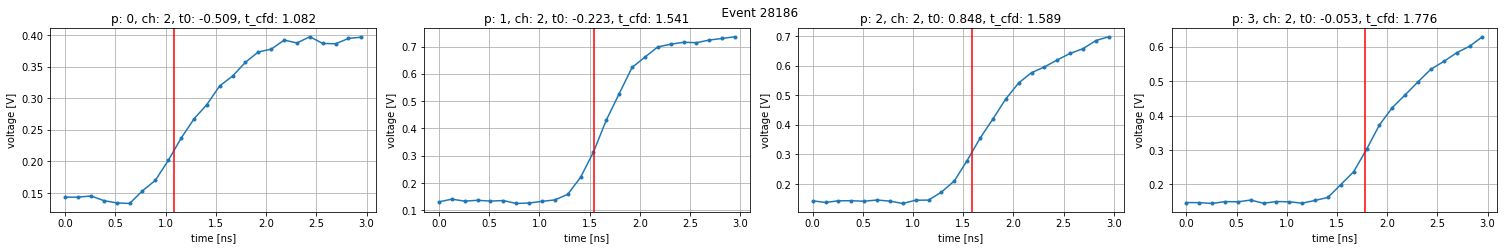

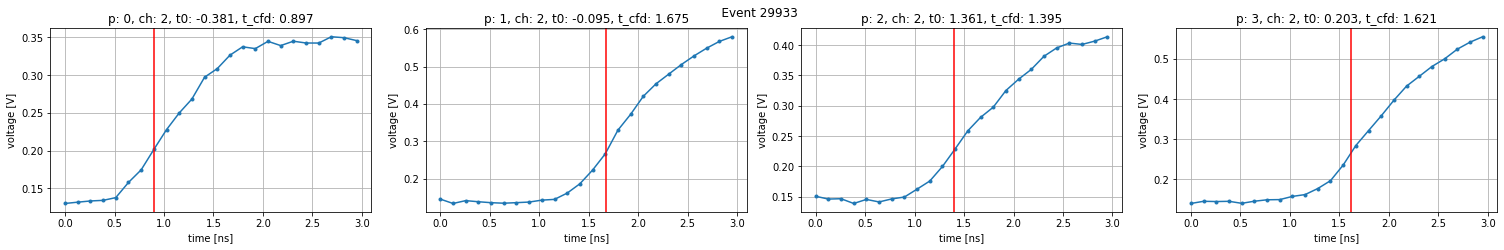

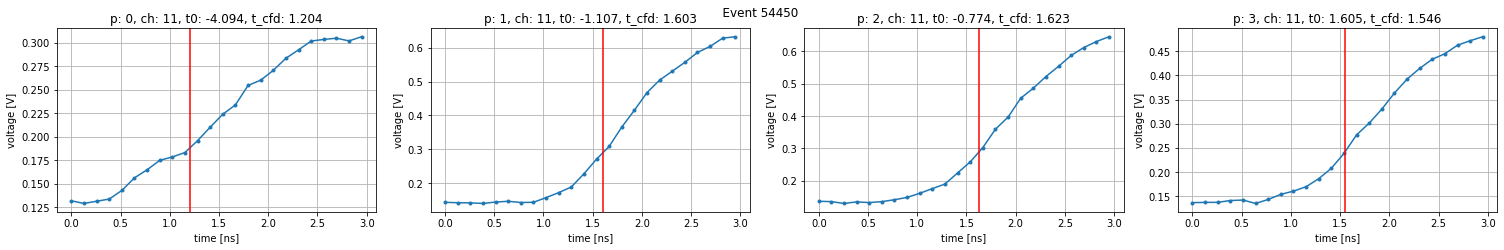

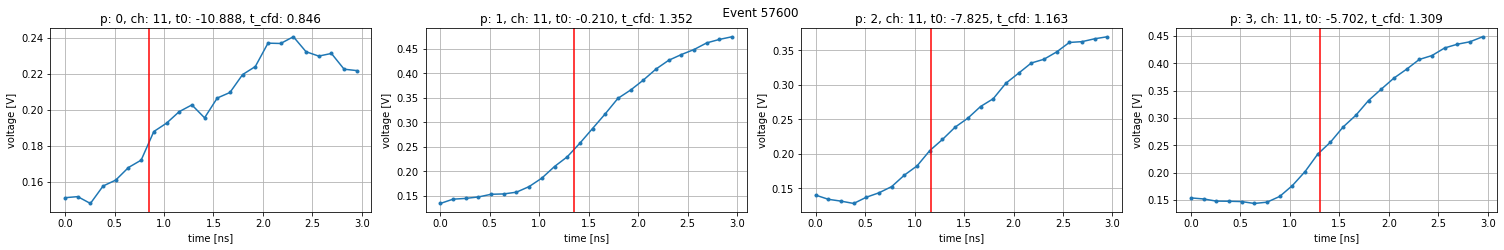

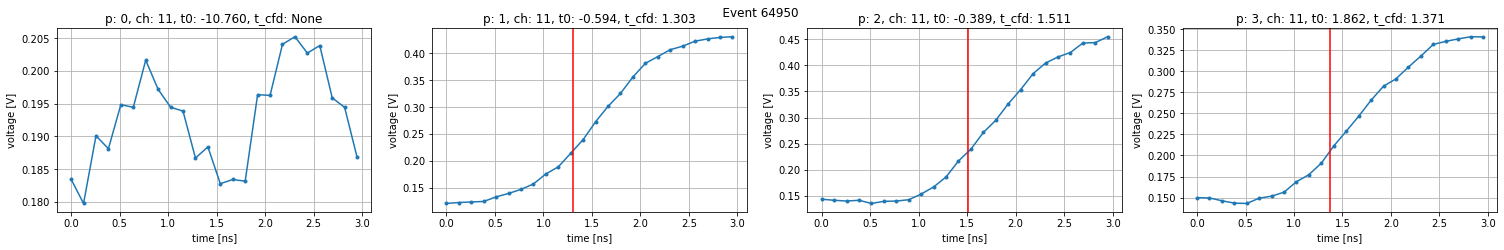

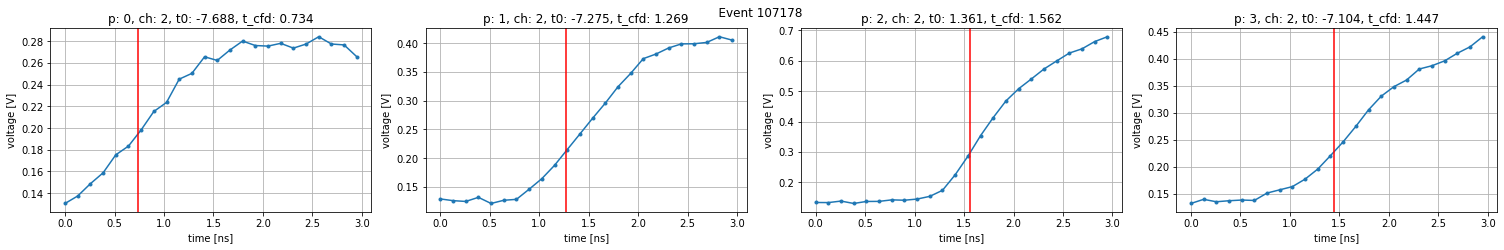

In [18]:
for event in events_to_view:
    plt.figure(figsize=(21, 3.5))
    
    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 4, i + 1)
        plt.plot(wav_data.series[0], -wav_data.series[1] + 1, marker='.')
        if wav_data.t_cfd is not None:
            plt.axvline(wav_data.t_cfd, c='red')
        # plt.ylim(0, 1)
        t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.3f}, t_cfd: {t_cfd_str}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.grid()
    
    plt.tight_layout()
    plt.suptitle(f'    Event {event}')
    
    plt.show()

In [16]:
for event in events_to_view[:2]:
    print('Event:', event)
    pprint(dataset[event].get_metadata_dict())

Event: 19792
{'plane 0': {'channel 11': "{'t0': -3.9653007984161377, 'fpga_timestamp': "
                           "7264059, 'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 29, 't_cfd': 0.9273672634413352}"},
 'plane 1': {'channel 11': "{'t0': -0.5942965149879456, 'fpga_timestamp': "
                           "7264031, 'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 24, 't_cfd': 1.4320770699913619}"},
 'plane 2': {'channel 11': "{'t0': -0.3890962600708008, 'fpga_timestamp': "
                           "7264057, 'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 23, 't_cfd': 1.5977172750149782}"},
 'plane 3': {'channel 11': "{'t0': 1.8617180585861206, 'fpga_timestamp': "
                           "7264030, 'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 25, 't_cfd': 1.6063120202852899}"}}
Event: 24253
{'plane 0': {'channel 11': "{'t0': -11.01658344